# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Retrieve Hourly and Daily Precipitaton Data

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



# Hourly Precipitation Data

##  ASOS Data Download from Iowa Environmental Mesonet (IEM)

Source: https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#

In [3]:
url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=NYC&data=p01m&year1=1940&month1=1&day1\
=1&year2=2023&month2=9&day2=11&tz=Etc%2FUTC&format\=onlycomma&latlon=no&elev=no&missing=null&trace=null&direct=\
no&report_type=3'

df = pd.read_csv(url)
print('shape of data: {}'.format(df.shape))

df.head()

shape of data: (308370, 3)


,station,valid,p01m
0,NYC,1943-12-01 05:00,NaN
1,NYC,1943-12-01 06:00,NaN
2,NYC,1943-12-01 07:00,NaN
3,NYC,1943-12-01 08:00,NaN
4,NYC,1943-12-01 09:00,NaN


In [4]:
## mm to inches
df['p01inch'] = round(df['p01m'] / 25.4, 4)

## to datetime
df['datetime'] = pd.to_datetime(df['valid'])
print('new hourly dtype: {}'.format(df['datetime'].dtype))

# preview data
df.head()

new hourly dtype: datetime64[ns]


,station,valid,p01m,p01inch,datetime
0,NYC,1943-12-01 05:00,NaN,NaN,1943-12-01 05:00:00
1,NYC,1943-12-01 06:00,NaN,NaN,1943-12-01 06:00:00
2,NYC,1943-12-01 07:00,NaN,NaN,1943-12-01 07:00:00
3,NYC,1943-12-01 08:00,NaN,NaN,1943-12-01 08:00:00
4,NYC,1943-12-01 09:00,NaN,NaN,1943-12-01 09:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308370 entries, 0 to 308369
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   308370 non-null  object        
 1   valid     308370 non-null  object        
 2   p01m      111869 non-null  float64       
 3   p01inch   111869 non-null  float64       
 4   datetime  308370 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 11.8+ MB


In [6]:
df.describe()

,p01m,p01inch
count,111869.000000,111869.000000
mean,0.348375,0.013714
std,1.488923,0.058619
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,80.010000,3.150000


In [7]:
# identify first non null value by datetime
(df
 .sort_values(by='valid')
 .loc[df['p01m'].notnull()]
)

,station,valid,p01m,p01inch,datetime
5121,NYC,1965-01-02 18:00,0.51,0.0201,1965-01-02 18:00:00
5122,NYC,1965-01-02 21:00,1.27,0.0500,1965-01-02 21:00:00
5123,NYC,1965-01-03 00:00,1.27,0.0500,1965-01-03 00:00:00
5126,NYC,1965-01-03 09:00,0.25,0.0098,1965-01-03 09:00:00
5167,NYC,1965-01-08 12:00,2.03,0.0799,1965-01-08 12:00:00
...,...,...,...,...,...
308363,NYC,2023-09-10 17:51,0.25,0.0098,2023-09-10 17:51:00
308366,NYC,2023-09-10 20:51,0.00,0.0000,2023-09-10 20:51:00
308367,NYC,2023-09-10 21:51,0.00,0.0000,2023-09-10 21:51:00
308368,NYC,2023-09-10 22:51,0.00,0.0000,2023-09-10 22:51:00


In [8]:
# retrieving data starting at first observation
start = (
    df
    .sort_values(by='valid')
    .loc[df['p01m'].notnull()]
    .head(1)
    .index[0]
)

df = (
    df
    .iloc[start:]
    .reset_index(drop=True)
)

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (303249, 5)


,station,valid,p01m,p01inch,datetime
0,NYC,1965-01-02 18:00,0.51,0.0201,1965-01-02 18:00:00
1,NYC,1965-01-02 21:00,1.27,0.0500,1965-01-02 21:00:00
2,NYC,1965-01-03 00:00,1.27,0.0500,1965-01-03 00:00:00
3,NYC,1965-01-03 03:00,NaN,NaN,1965-01-03 03:00:00
4,NYC,1965-01-03 06:00,NaN,NaN,1965-01-03 06:00:00


In [9]:
# dataframe of hourly precipitation >= 1.75
df.loc[df['p01inch'] >= 1.75]

,station,valid,p01m,p01inch,datetime
138032,NYC,2004-09-08 11:51,44.70,1.7598,2004-09-08 11:51:00
285345,NYC,2021-08-22 03:51,49.28,1.9402,2021-08-22 03:51:00
285607,NYC,2021-09-02 01:51,80.01,3.1500,2021-09-02 01:51:00


In [10]:
counts = len(df.loc[df['p01inch'] >= 1.75])

print('Number of hourly observations with >= 1.75 inches of precipitation: {}'.format(counts))

Number of hourly observations with >= 1.75 inches of precipitation: 3


In [11]:
# records in print view
records = (
    df
    .loc[df['p01inch'] >= 1.75, ['valid', 'p01inch']]
    .sort_values(by='p01inch', ascending=False)
    .set_index('valid')
)

print(records)

                  p01inch
valid                    
2021-09-02 01:51   3.1500
2021-08-22 03:51   1.9402
2004-09-08 11:51   1.7598


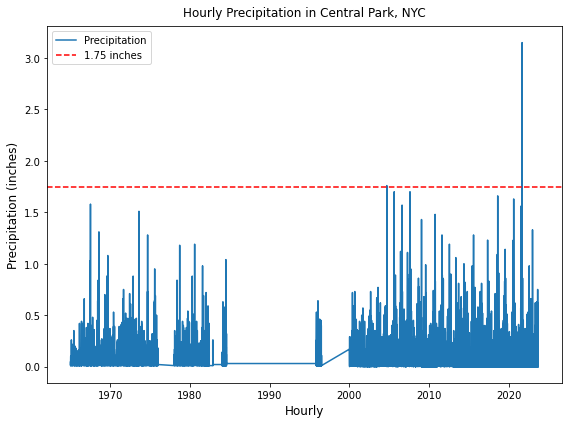

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df,
    x=df['datetime'],
    y=df['p01inch'],
    label='Precipitation'
)

plt.title(
    'Hourly Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r',linestyle='--', label='1.75 inches')

plt.legend(loc=2)
plt.xlabel('Hourly', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

# Daily Precipitation Data

## NCEI Climate Data Online's Daily Summaries, NY CITY CENTRAL PARK, NY US

Source: https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

In [13]:
df = pd.read_csv('data/daily-precipitation.csv')

## to datetime
df['datetime'] = pd.to_datetime(df['DATE'])
print('new dtype: {}'.format(df['datetime'].dtype))

# preview data
print(df.shape)
df.head()

new dtype: datetime64[ns]
(56498, 9)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,datetime
0,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-01,0.75,",,Z,",1869-01-01
1,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-02,0.03,",,Z,null",1869-01-02
2,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-03,0.00,"T,,Z,null",1869-01-03
3,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-04,0.18,",,Z,null",1869-01-04
4,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-05,0.05,",,Z,null",1869-01-05


## The number of days with extreme rainfall
(defined as days of rainfall over 1.75 inches in Central Park) 

In [14]:
counts = len(df.loc[df['PRCP'] >= 1.75])

print('Total number of daily observations with >= 1.75 inches of precipitation: {}'.format(counts))

Total number of daily observations with >= 1.75 inches of precipitation: 543


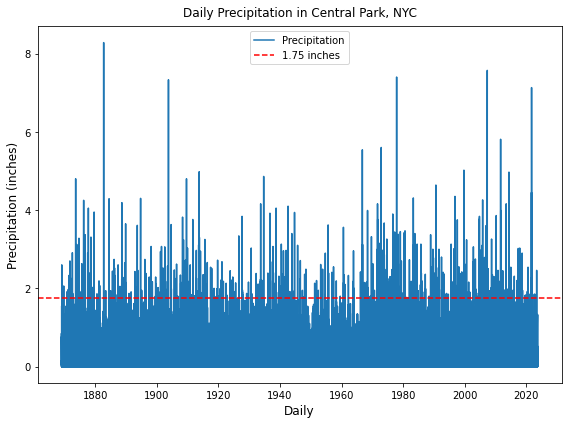

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df,
    x=df.set_index('datetime').index,
    y=df['PRCP'],
    label='Precipitation'
)

plt.title(
    'Daily Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r', linestyle='--', label='1.75 inches')

plt.legend(loc='upper center')
plt.xlabel('Daily', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

In [16]:
df.loc[df['PRCP'] >= 1.75, ['threshold']] = 1

bins = [x for x in range(1860, 2040, 10)]
df['bins'] = pd.cut(df['datetime'].dt.year, bins=bins)

data = (
    df
    .groupby(by='bins')['threshold']
    .sum()
    .astype(int)
    .rename('count')
    .reset_index()
)

# preview dataframe
data

,bins,count
0,"(1860, 1870]",4
1,"(1870, 1880]",33
2,"(1880, 1890]",30
3,"(1890, 1900]",26
4,"(1900, 1910]",41
5,"(1910, 1920]",36
6,"(1920, 1930]",27
7,"(1930, 1940]",32
8,"(1940, 1950]",21
9,"(1950, 1960]",22


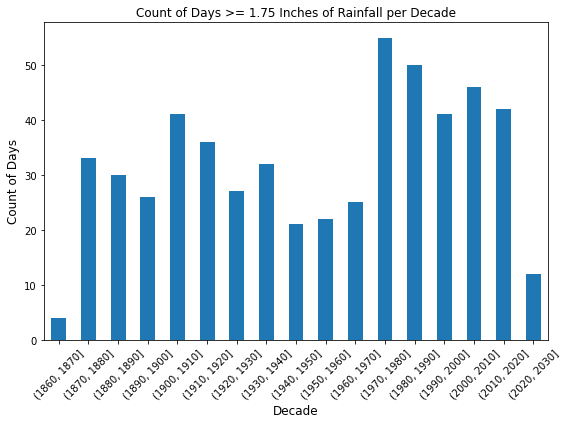

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

data.plot.bar(
    x='bins',
    y='count',
    rot=45,
    legend=None,
    ax=ax 
)

plt.title('Count of Days >= 1.75 Inches of Rainfall per Decade', fontsize=12)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Count of Days', fontsize=12)
plt.tight_layout()